In [1]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import numpy as np
from pathlib import Path
import sys
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import copy
from scipy.spatial import distance
import math

In [2]:
sys.path.insert(0, '..')

In [3]:
from functions.utils import get_file, save_file
from functions.bert import Dataset, BertClassifier, evaluate_model, inference_model

In [4]:
from jupyterthemes import jtplot
jtplot.reset()
sns.set(rc={'figure.figsize': (6, 4)})

In [5]:
MODEL_PATH = Path('../models')
CONTRACT_PATH = Path('../docs')

In [6]:
OUTP_DIM = 312
BATCH_SIZE = 6
N_CATS = 5
MAX_LEN = 100

In [7]:
#tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model = BertClassifier(bert_model, N_CATS, OUTP_DIM)

In [9]:
model.load_state_dict(torch.load(MODEL_PATH / 'rubert_tiny_state_dict.pkl', map_location=torch.device('cpu')))
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=Tr

In [10]:
tokenizer = get_file(MODEL_PATH / 'tokenizer_rubert.pkl')
idx2item = get_file(MODEL_PATH / 'idx2item.pkl')

In [11]:
item2idx = {v: k for k, v in idx2item.items()}

In [12]:
data = get_file(CONTRACT_PATH / 'sents_df_100.pkl')

In [13]:
data_val = data[data.data_split == 'val'][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]
data_test = data[data.data_split == 'test'][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]

In [14]:
val_data = Dataset(data_val, tokenizer, MAX_LEN, item2idx)
test_data = Dataset(data_test, tokenizer, MAX_LEN, item2idx)

100%|████████████████████████████████████| 1007/1007 [00:00<00:00, 5096.82it/s]


In [15]:
# Оценка на валидационной выборке

pred_labels, pred_probs = evaluate_model(model, val_data, BATCH_SIZE, return_proba=True)

data_val_with_preds = data_val.copy()

data_val_with_preds['target_pred'] = pred_labels
data_val_with_preds['pred_proba'] = pred_probs
data_val_with_preds['target_pred'] = data_val_with_preds['target_pred'].map(idx2item)

print('\nVAL DATA (sentences):\n', classification_report(data_val_with_preds.target, data_val_with_preds.target_pred))

100%|████████████████████████████████████████| 172/172 [00:13<00:00, 13.13it/s]

Accuracy:  0.735

VAL DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.81      0.75      0.78       204
 Договоры купли-продажи       0.87      0.58      0.70       176
Договоры оказания услуг       0.51      0.79      0.62       148
       Договоры подряда       0.90      0.74      0.81       298
      Договоры поставки       0.66      0.80      0.72       205

               accuracy                           0.74      1031
              macro avg       0.75      0.73      0.73      1031
           weighted avg       0.77      0.74      0.74      1031



In [16]:
pred_df = data_val_with_preds.groupby('file_name').target_pred.value_counts(normalize=True).to_frame()
pred_df.columns = ['proba']
pred_df.reset_index(inplace=True)

true_df = data_val_with_preds[['file_name', 'target']].drop_duplicates()

pred_df = pred_df.merge(true_df)
pred_df['ord'] = pred_df.groupby('file_name').cumcount()

In [17]:
most_imp_snts = data_val_with_preds.merge(pred_df[['file_name', 'target_pred']], how='right') \
    .sort_values(by=['file_name', 'pred_proba'], ascending=[True, False])

most_imp_snts['aware_ord'] = most_imp_snts.groupby('file_name').cumcount()

In [18]:
most_imp_snts.head(10)

,sentence_clear,target,file_name,snt_order,sentence,target_pred,pred_proba,aware_ord
24,ответственность сторон при неисполнении ненадл...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,28,"ОТВЕТСТВЕННОСТЬ СТОРОН 5.1. При неисполнении, ...",Договоры подряда,0.940859,0
15,заказчик оплачивает подрядчику обусловленную п...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,19,Заказчик оплачивает Подрядчику обусловленную п...,Договоры подряда,0.940470,1
9,при просрочке выполнения работ по устранению н...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,11,При просрочке выполнения работ по устранению н...,Договоры подряда,0.936662,2
19,заказчик обязан в срок с участием подрядчика о...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,23,Заказчик обязан в срок________________________...,Договоры подряда,0.936233,3
1,предмет договора подрядчик обязуется выполнить...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,2,ПРЕДМЕТ ДОГОВОРА 1.1. Подрядчик обязуется выпо...,Договоры подряда,0.936174,4
6,качество выполненной подрядчиком работы должно...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,7,Качество выполненной Подрядчиком работы должно...,Договоры подряда,0.934330,5
7,подрядчик гарантирует качество выполненной раб...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,8,Подрядчик гарантирует качество _______________...,Договоры подряда,0.934042,6
26,при неисполнении заказчиком обязанности уплати...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,30,При неисполнении Заказчиком обязанности уплати...,Договоры подряда,0.933482,7
14,в случаях если фактические расходы подрядчика ...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,18,"3.2. В случаях, если фактические расходы Подря...",Договоры подряда,0.933057,8
18,для обеспечения своевременного выполнения рабо...,Договоры подряда,03a70fe60be9ecc2a63798a361fc9689.docx,22,Для обеспечения своевременного выполнения рабо...,Договоры подряда,0.932841,9


In [19]:
[print(x, end='\n\n------------------------\n\n') for x in most_imp_snts[most_imp_snts.aware_ord < 5].sentence.values[:5]]

ОТВЕТСТВЕННОСТЬ СТОРОН 5.1. При неисполнении, ненадлежащем исполнении принятых на себя обязательств стороны несут следующую ответственность: Подрядчик: — за некачественное выполнение работ — _______________________; (мера ответственности) — за просрочку выполнения работ — ____________________________; (мера ответственности) — за непередачу оговоренной в пункт 4.7 договора информации — ___________________________________________________________________.

------------------------

Заказчик оплачивает Подрядчику обусловленную пункт 3.1 договора стоимость работ ____________________________________________________________________________ (указать порядок оплаты — после окончания работы согласно акту приемки, или досрочно в качестве предоплаты, или иной порядок) (срок) ____________________________________________________________________________ ____________________________________ в течение ____________________.

------------------------

При просрочке выполнения работ по устранению недостат

[None, None, None, None, None]

In [20]:
pred_df[pred_df.ord == 0]

,file_name,target_pred,proba,target,ord
0,03a70fe60be9ecc2a63798a361fc9689.docx,Договоры подряда,0.828571,Договоры подряда,0
4,073a0d372820c3c2bffe9ba24a7ed7af.doc,Договоры купли-продажи,0.692308,Договоры купли-продажи,0
8,084edc7dfc3db04e3a3c55c102f47bcb.doc,Договоры аренды,0.882353,Договоры аренды,0
12,086ad48895d2a73854b6151decc28800.pdf,Договоры купли-продажи,0.627451,Договоры купли-продажи,0
17,0ca2f9faecdbc67d6686a9f5b6636eba.doc,Договоры купли-продажи,0.736842,Договоры купли-продажи,0
21,137eaaa047f557233943012897e46cec.doc,Договоры поставки,0.512821,Договоры купли-продажи,0
25,2fd747f38e30ae7ce1c9d6e3b907ac5d.doc,Договоры поставки,0.739130,Договоры поставки,0
30,6b18c046e7ccfdaf9123c11980f56c35.doc,Договоры подряда,0.720930,Договоры подряда,0
34,7a120d4c7cec157324effa671e2d0812.docx,Договоры подряда,0.693182,Договоры подряда,0
38,86d6d0062e91651ccc3d3ce35b162bf8.doc,Договоры купли-продажи,0.500000,Договоры купли-продажи,0


In [21]:
print('\nVAL DATA (Documents):\n', classification_report(pred_df[pred_df.ord == 0].target, pred_df[pred_df.ord == 0].target_pred))


VAL DATA (Documents):
                          precision    recall  f1-score   support

        Договоры аренды       1.00      1.00      1.00         3
 Договоры купли-продажи       1.00      0.80      0.89         5
Договоры оказания услуг       1.00      1.00      1.00         3
       Договоры подряда       1.00      1.00      1.00         4
      Договоры поставки       0.75      1.00      0.86         3

               accuracy                           0.94        18
              macro avg       0.95      0.96      0.95        18
           weighted avg       0.96      0.94      0.95        18



In [22]:
# Оценка на тестовой выборке

pred_test_labels, pred_test_probs = inference_model(model, test_data, BATCH_SIZE, return_proba=True)

data_test_with_preds = data_test.copy()

data_test_with_preds['target_pred'] = pred_test_labels
data_test_with_preds['pred_proba'] = pred_test_probs
data_test_with_preds['target_pred'] = data_test_with_preds['target_pred'].map(idx2item)

print('\nTEST DATA (sentences):\n', classification_report(data_test_with_preds.target, data_test_with_preds.target_pred))

100%|████████████████████████████████████████| 168/168 [00:16<00:00, 10.35it/s]


TEST DATA (sentences):
                          precision    recall  f1-score   support

        Договоры аренды       0.69      0.83      0.76        99
 Договоры купли-продажи       0.94      0.51      0.66       177
Договоры оказания услуг       0.78      0.80      0.79       409
       Договоры подряда       0.72      0.71      0.71       181
      Договоры поставки       0.57      0.78      0.66       141

               accuracy                           0.73      1007
              macro avg       0.74      0.73      0.72      1007
           weighted avg       0.76      0.73      0.73      1007



In [23]:
pred_df[pred_df.ord == 0][pred_df.target_pred != pred_df.target]

<ipython-input-23-d864ac8124fc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_df[pred_df.ord == 0][pred_df.target_pred != pred_df.target]


,file_name,target_pred,proba,target,ord
21,137eaaa047f557233943012897e46cec.doc,Договоры поставки,0.512821,Договоры купли-продажи,0


In [24]:
pred_df = data_test_with_preds.groupby('file_name').target_pred.value_counts(normalize=True).to_frame()
pred_df.columns = ['proba']
pred_df.reset_index(inplace=True)

true_df = data_test_with_preds[['file_name', 'target']].drop_duplicates()

pred_df = pred_df.merge(true_df)
pred_df['ord'] = pred_df.groupby('file_name').cumcount()

In [25]:
most_imp_snts = data_test_with_preds.merge(pred_df[['file_name', 'target_pred']], how='right') \
    .sort_values(by=['file_name', 'pred_proba'], ascending=[True, False])

most_imp_snts['aware_ord'] = most_imp_snts.groupby('file_name').cumcount()

In [26]:
print('\nTEST DATA (Documents):\n', classification_report(pred_df[pred_df.ord == 0].target, pred_df[pred_df.ord == 0].target_pred))


TEST DATA (Documents):
                          precision    recall  f1-score   support

        Договоры аренды       1.00      1.00      1.00         3
 Договоры купли-продажи       1.00      0.75      0.86         4
Договоры оказания услуг       0.83      1.00      0.91         5
       Договоры подряда       1.00      1.00      1.00         3
      Договоры поставки       1.00      1.00      1.00         3

               accuracy                           0.94        18
              macro avg       0.97      0.95      0.95        18
           weighted avg       0.95      0.94      0.94        18



In [27]:
pred_df[pred_df.ord == 0][pred_df.target_pred != pred_df.target]

<ipython-input-27-d864ac8124fc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred_df[pred_df.ord == 0][pred_df.target_pred != pred_df.target]


,file_name,target_pred,proba,target,ord
60,f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры оказания услуг,0.3875,Договоры купли-продажи,0


In [13]:
from functions.data_prepare import get_doc_text, prepare_sents_dataset
from os.path import splitext

In [24]:
def get_doc_info(file_obj, model, tokenizer, idx2item):
    # Определение типа документа и возврат аналитики по нему
    doc_text = get_doc_text(file_obj).strip()
    _, file_ext = splitext(file_obj.name)
    docs_data = pd.DataFrame([{'FileName': file_obj.name, 'Format': file_ext[1:], 'Content': doc_text}])
    data = prepare_sents_dataset(docs_data, inference=True)
    test_data = Dataset(data[['sentence_clear', 'file_name', 'snt_order', 'sentence']], tokenizer, MAX_LEN, item2idx)
    data['target_pred'], data['pred_proba'] = inference_model(model, test_data, BATCH_SIZE, return_proba=True)
    data['target_pred'] = data['target_pred'].map(idx2item)
    return data

In [39]:
fn = '1ea8809d696a4bd6a2076fbc6fd28c23.doc'

with open(CONTRACT_PATH / fn, 'rb') as f:
    data = get_doc_info(f, model, tokenizer, idx2item)

1it [00:00, 166.63it/s]
100%|██████████████████████████████████████████| 17/17 [00:01<00:00, 13.68it/s]


In [40]:
data

,file_name,snt_order,sentence,sentence_clear,data_split,target,target_pred,pred_proba
0,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,1,ДОГОВОР № ______ ДОГОВОР Москва «_____» ______...,договор договор москва года гражданин рф года ...,,,Договоры купли-продажи,0.839564
1,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,2,"Предмет Договора. 1.1. Продавец продает, а Пок...",предмет договора продавец продает а покупатель...,,,Договоры купли-продажи,0.881666
2,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,3,Квартира расположена по адресу: ______________...,квартира расположена по адресу,,,Договоры купли-продажи,0.370951
3,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,4,Квартира имеет следующие характеристики: Кварт...,квартира имеет следующие характеристики кварти...,,,Договоры купли-продажи,0.824908
4,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,5,Основанием возникновения права собственности П...,основанием возникновения права собственности п...,,,Договоры купли-продажи,0.846187
...,...,...,...,...,...,...,...,...
95,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,96,7.15. Настоящий Договор составлен и подписан в...,настоящий договор составлен и подписан в трех ...,,,Договоры купли-продажи,0.456339
96,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,97,Каждая страница каждого экземпляра настоящего ...,каждая страница каждого экземпляра настоящего ...,,,Договоры купли-продажи,0.851586
97,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,98,АДРЕСА СТОРОН Продавец: ______________________...,адреса сторон продавец адрес регистрации прода...,,,Договоры купли-продажи,0.886722
98,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,99,Любые условия могут быть изменены в зависимост...,любые условия могут быть изменены в зависимост...,,,Договоры оказания услуг,0.547987


In [41]:
ret = data.target_pred.value_counts(normalize=True).to_frame().reset_index()
ret.columns = ['Тип договора', 'Вероятность']

In [42]:
ret

,Тип договора,Вероятность
0,Договоры купли-продажи,0.52
1,Договоры оказания услуг,0.29
2,Договоры аренды,0.13
3,Договоры поставки,0.05
4,Договоры подряда,0.01


In [43]:
data.sort_values(by='pred_proba', ascending=False, inplace=True)

In [44]:
data

,file_name,snt_order,sentence,sentence_clear,data_split,target,target_pred,pred_proba
52,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,53,5.1.4. Оплатить стоимость всех коммунальных ус...,оплатить стоимость всех коммунальных услуг а т...,,,Договоры оказания услуг,0.903839
97,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,98,АДРЕСА СТОРОН Продавец: ______________________...,адреса сторон продавец адрес регистрации прода...,,,Договоры купли-продажи,0.886722
16,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,17,3.5. Продавец получает доступ к указанной банк...,продавец получает доступ к указанной банковско...,,,Договоры купли-продажи,0.885505
58,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,59,5.2.4. Уплатить Покупателю цену за Квартиру в ...,уплатить покупателю цену за квартиру в порядке...,,,Договоры купли-продажи,0.885203
9,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,10,При передаче Квартиры Продавец обязан передать...,при передаче квартиры продавец обязан передать...,,,Договоры купли-продажи,0.885092
...,...,...,...,...,...,...,...,...
91,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,92,В зависимости от выбора варианта редакции пунк...,в зависимости от выбора варианта редакции пунк...,,,Договоры оказания услуг,0.253949
19,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,20,"3.7. Стороны установили, что предусмотренное п...",стороны установили что предусмотренное пункт ст,,,Договоры купли-продажи,0.248886
38,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,39,В зависимости от конкретной ситуации необходим...,в зависимости от конкретной ситуации необходим...,,,Договоры оказания услуг,0.243401
45,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,46,В зависимости от конкретной ситуации необходим...,в зависимости от конкретной ситуации необходим...,,,Договоры оказания услуг,0.243401


In [49]:
possible_types = ret[ret['Вероятность'] >= 0.2]['Тип договора'].values

possible_types

array(['Договоры купли-продажи', 'Договоры оказания услуг'], dtype=object)

In [52]:
imp_phrases = {}

for doc_type in possible_types:
    imp_phrases[doc_type] = data[data.target_pred == doc_type].head(5).sentence.values

In [53]:
imp_phrases

{'Договоры купли-продажи': array(['АДРЕСА СТОРОН Продавец: ______________________________ (адрес регистрации Продавца) Покупатель: ______________________________ (адрес регистрации Покупателя) ПОДПИСИ СТОРОН Продавец: ________________/_______________ (подпись) (ФИО) Покупатель: ________________/_____________ (подпись) (ФИО) Примечания: Выше приводится вариант типового документа, который содержит наиболее распространенные условия и не учитывает индивидуальных особенностей.',
        '3.5. Продавец получает доступ к указанной банковской ячейке после государственной регистрации права собственности Покупателя на Квартиру, указанную в пункт 1 настоящего Договора, при предъявлении в Банк следующих документов: _________________________________________________________________________ .',
        '5.2.4. Уплатить Покупателю цену за Квартиру в порядке, установленном настоящим Договором, а именно: в присутствии Продавца поместить денежную сумму, указанную в пункт 3.2 настоящего Договора, в банков

In [54]:
data[data.target_pred == doc_type]

,file_name,snt_order,sentence,sentence_clear,data_split,target,target_pred,pred_proba
52,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,53,5.1.4. Оплатить стоимость всех коммунальных ус...,оплатить стоимость всех коммунальных услуг а т...,,,Договоры оказания услуг,0.903839
99,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,100,Использование этого типового документа в реаль...,использование этого типового документа в реаль...,,,Договоры оказания услуг,0.715574
30,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,31,"Каких-либо лиц, имеющих обоснованную возможнос...",каких либо лиц имеющих обоснованную возможност...,,,Договоры оказания услуг,0.699807
72,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,73,7.2. Настоящий Договор регулируется граждански...,настоящий договор регулируется гражданским зак...,,,Договоры оказания услуг,0.576424
98,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,99,Любые условия могут быть изменены в зависимост...,любые условия могут быть изменены в зависимост...,,,Договоры оказания услуг,0.547987
81,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,82,"7.7. Никакие уведомления, направленные одной С...",никакие уведомления направленные одной стороно...,,,Договоры оказания услуг,0.543122
59,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,60,"5.2.5. Выполнять иные обязанности, вытекающие ...",выполнять иные обязанности вытекающие из насто...,,,Договоры оказания услуг,0.539454
54,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,55,"5.1.6. Выполнять иные обязанности, вытекающие ...",выполнять иные обязанности вытекающие из насто...,,,Договоры оказания услуг,0.539454
86,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,87,"7.10. Каждая Сторона подтверждает, что понимае...",каждая сторона подтверждает что понимает все у...,,,Договоры оказания услуг,0.531182
68,..\docs\1ea8809d696a4bd6a2076fbc6fd28c23.doc,69,7. Заключительные положения. 7.1. Настоящий До...,заключительные положения настоящий договор счи...,,,Договоры оказания услуг,0.503712


In [48]:
data[data.target_pred]

array(['Договоры купли-продажи', 'Договоры оказания услуг'], dtype=object)

In [19]:
ret['Тип договора'][0]

'Договоры аренды'

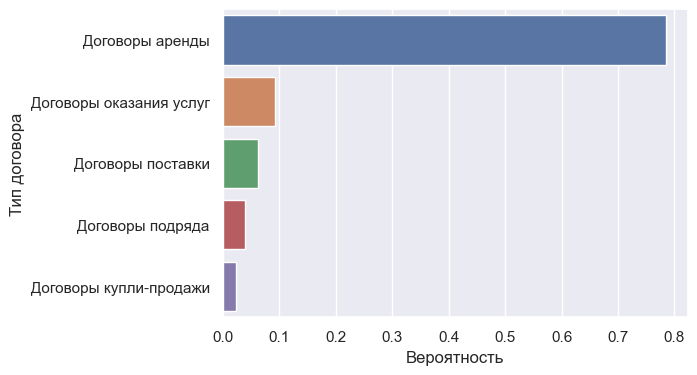

In [20]:
sns.barplot(y=ret['Тип договора'], x=ret['Вероятность'], orient='h')
plt.show()

In [13]:
model_emb = copy.deepcopy(model)

model_emb.linear = nn.Identity()
model_emb.relu = nn.Identity()
model_emb.dropout = nn.Identity()

In [14]:
from tqdm import tqdm

def get_model_embs(model, test_data, batch_size):

    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    model.eval()
    
    embs = []

    with torch.no_grad():
        for test_input, _ in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output_embs = model(input_id, mask)
            embs.append(output_embs)
    
    return torch.cat(embs).cpu().numpy()

In [15]:
data_train = data[data.data_split.isin(['train', 'val'])][['sentence_clear', 'target', 'file_name', 'snt_order', 'sentence']]
train_data = Dataset(data_train, tokenizer, MAX_LEN, item2idx)

100%|████████████████████████████████████| 6083/6083 [00:01<00:00, 4674.16it/s]


In [16]:
embs = get_model_embs(model_emb, train_data, BATCH_SIZE)

100%|██████████████████████████████████████| 1014/1014 [01:14<00:00, 13.69it/s]


In [17]:
data_train['embs'] = [emb for emb in embs]

mean_embs = data_train.groupby(['file_name', 'target'], as_index=False).embs.mean()

In [18]:
tsne = TSNE(n_components=2, init='random', learning_rate=100)
doc_embs_transformed = tsne.fit_transform(mean_embs.embs.values.tolist())

In [19]:
mean_embs['emb_tsne'] = [x for x in doc_embs_transformed]

In [20]:
mean_embs.head()

,file_name,target,embs,emb_tsne
0,02682d726b725f95b9ee85f751c043d0.doc,Договоры оказания услуг,"[-0.07566662, 0.30619746, -0.4706463, 0.373515...","[6.6189733, 8.211763]"
1,03a70fe60be9ecc2a63798a361fc9689.docx,Договоры подряда,"[0.053905807, 0.37731495, -0.2506324, 0.422970...","[5.5235715, 4.3214116]"
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,Договоры купли-продажи,"[0.31785217, -0.29523638, -0.34069136, -0.3954...","[-0.28185257, -2.129463]"
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,Договоры аренды,"[-0.4672431, -0.1307142, -0.5617255, -0.248879...","[-2.3501053, 2.194168]"
4,086ad48895d2a73854b6151decc28800.pdf,Договоры купли-продажи,"[0.39380455, -0.34897813, -0.2562234, -0.42766...","[-0.09564677, -2.7185748]"


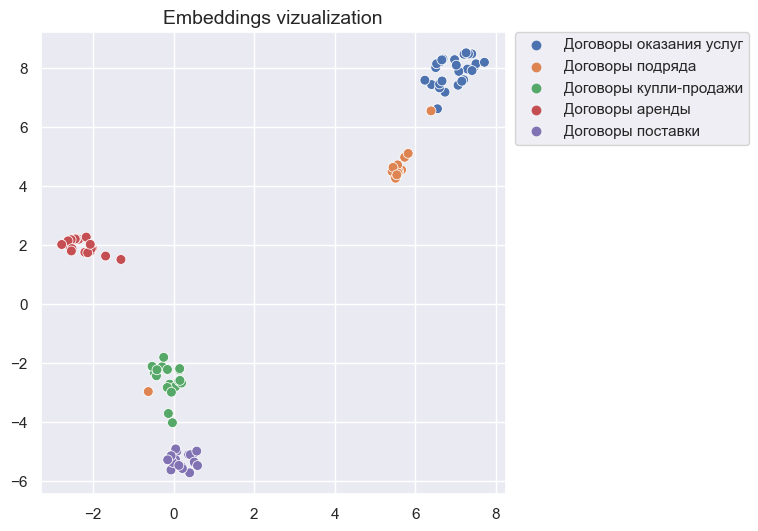

In [21]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=[data[0] for data in mean_embs.emb_tsne],
                y=[data[1] for data in mean_embs.emb_tsne],
                hue=[data for data in mean_embs.target],
                palette='deep',
                s=50)
plt.title('Embeddings vizualization', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [22]:
target2emb = mean_embs.groupby('target').embs.mean().to_dict()

In [23]:
save_file(target2emb, MODEL_PATH / 'target2emb.pkl')

'Done'

In [25]:
mean_embs['target_mean_emb'] = mean_embs.target.map(target2emb)

In [26]:
mean_embs.head()

,file_name,target,embs,emb_tsne,target_mean_emb
0,02682d726b725f95b9ee85f751c043d0.doc,Договоры оказания услуг,"[-0.07566662, 0.30619746, -0.4706463, 0.373515...","[6.6189733, 8.211763]","[-0.052047703, 0.3287965, -0.5257323, 0.469986..."
1,03a70fe60be9ecc2a63798a361fc9689.docx,Договоры подряда,"[0.053905807, 0.37731495, -0.2506324, 0.422970...","[5.5235715, 4.3214116]","[0.07009992, 0.31066287, -0.31450033, 0.375512..."
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,Договоры купли-продажи,"[0.31785217, -0.29523638, -0.34069136, -0.3954...","[-0.28185257, -2.129463]","[0.34332696, -0.32635632, -0.28109106, -0.4120..."
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,Договоры аренды,"[-0.4672431, -0.1307142, -0.5617255, -0.248879...","[-2.3501053, 2.194168]","[-0.42129883, -0.13431546, -0.5380993, -0.2542..."
4,086ad48895d2a73854b6151decc28800.pdf,Договоры купли-продажи,"[0.39380455, -0.34897813, -0.2562234, -0.42766...","[-0.09564677, -2.7185748]","[0.34332696, -0.32635632, -0.28109106, -0.4120..."


In [27]:
mean_embs['target_distance'] = mean_embs.apply(lambda x: distance.cosine(x['embs'], x['target_mean_emb']), axis=1)

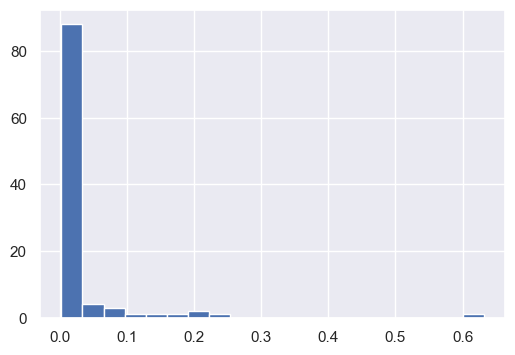

In [28]:
plt.hist(mean_embs['target_distance'], bins=20)
plt.show()

In [34]:
(mean_embs.target_distance >= 0.003).mean()

0.9019607843137255

In [36]:
save_file(mean_embs['target_distance'].values, MODEL_PATH / 'emb_distances.pkl')

'Done'

In [29]:
mean_embs[mean_embs.target_distance > 0.5]

,file_name,target,embs,emb_tsne,target_mean_emb,target_distance
81,b7acf29be1d3e4b9cb529683e676fadb.doc,Договоры подряда,"[0.3286826, -0.115809694, -0.31230178, -0.1241...","[-0.625237, -2.9697208]","[0.07009992, 0.31066287, -0.31450033, 0.375512...",0.632136


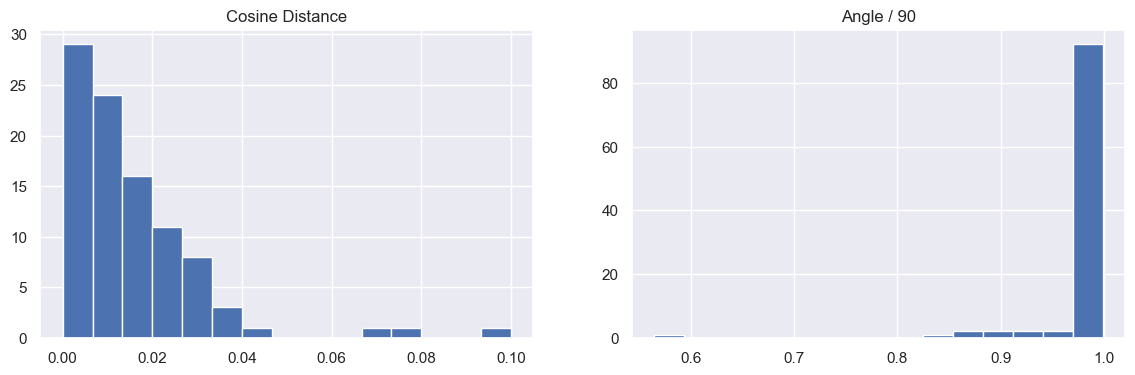

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax[0].hist(mean_embs['target_distance'], bins=15, range=(0, 0.1))
ax[0].set_title('Cosine Distance')

ax[1].hist(mean_embs['target_distance'].apply(lambda x: math.degrees(math.acos(x))) / 90, bins=15)
ax[1].set_title('Angle / 90')

plt.show()

In [ ]:
import copy
from scipy.spatial import distance
import math

In [2]:
def get_similarity_level(test_data, model, target_emb, batch_size):
    model_emb = copy.deepcopy(model)
    model_emb.linear = nn.Identity()
    model_emb.relu = nn.Identity()
    model_emb.dropout = nn.Identity()
    
    embs = get_model_embs(model_emb, test_data, batch_size=batch_size)
    print(embs.shape)
    
    dst = distance.cosine(embs, target_emb)
    return math.degrees(math.acos(dst)) / 90